# Intro to AI-driven Science on Supercomputers
## Week 3 Homework

#### Dan Horner (danhorner@berkeley.edu)¶
---

# Improving CIFAR-10 dataset classification with CNNs

## CIFAR-10 data set
In this homework, we use the CIFAR-10 data set, which contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

The original training image data (x_train_orig) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels, while y_train_orig is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

Since we are trying to evaluate performance of different models, we will be using a validation data set taken from the original training data set (80% train & 20% validation.).

## Set Up and Data Import


In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
np.random.seed(1)

# Plotting library
import plotnine as p9
from plotnine import * 
p9.options.figure_size = (15, 12)

import time

from image_dataset_loader import load

In [2]:
# Data import copied from in-class notebook, and adapted for Train/Validation/Test

(x_train_orig, y_train_orig), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#(x_train_orig, y_train_orig), (x_test, y_test) = load('../03_neural_networks_tensorflow/cifar10', ['train', 'test'])


x_train_orig = x_train_orig.astype(np.float32)
x_test  = x_test.astype(np.float32)

# Normalize values [0-1]
x_train_orig /= 255.
x_test  /= 255.

y_train_orig = y_train_orig.astype(np.int32)
y_test  = y_test.astype(np.int32)

#Train / validation split
x_train_i, x_val, y_train_i, y_val = train_test_split(x_train_orig, y_train_orig, test_size=0.2)

print('CIFAR-10 data loaded: train:',len(x_train_orig),'test:',len(x_test))
print('X_train:', x_train_i.shape)
print('y_train:', y_train_i.shape)
print('X_val:', x_val.shape)
print('y_val:', y_val.shape)
print('X_test:', x_test.shape)
print('y_test:', y_test.shape)

CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (40000, 32, 32, 3)
y_train: (40000, 1)
X_val: (10000, 32, 32, 3)
y_val: (10000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


---

## Model Training

### Function Definitions

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.relu, dropout=(0.25, 0.50), hl = (32, 64, 128)):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(hl[0], [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(hl[1], [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(dropout[0])
        self.dense_5 = tf.keras.layers.Dense(hl[2], activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(dropout[1])
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

In [4]:
def train_network_concise(_x_train, _y_train, _batch_size, _n_training_epochs, _lr, _dropout, _hl):
    model = CIFAR10Classifier(dropout = _dropout, hl = _hl)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])    
    history = model.fit(_x_train, _y_train, batch_size=_batch_size, epochs=_n_training_epochs, verbose=2)
    
    return history, model

## Results

To increase accuracy, I tuned a number of the hyper-parameters by hand, including the model layers themselves. In order to compare models, I varied the dropout and hidden layer dimensions via parameters passed to the model constructor.
Unsurprisingly, training for more epochs led to the greatest gain in accuracy. The model layer changes I investigated (adding additional convolutional and pooling layers) didn't seem to make a substantial difference to the accuracy, and accordingly I ended up using original layer sequence, but with different hyper-parameters and dimensions. Additionally, I used accuracy as the training metric.

The model with:
- batch size: 512
- learning rate: 0.10
- dropout: 50% before and 50% after the final dense layer
- two 2-D convolutional layers filter dimension: 128 and 256
- final dense layer dimension: 256 

resulted in 92% training accuracy and 73.5% test accuracy after 50 epochs. More hyper-parameter optimization could certainly be done and based on the figures below more training epochs would certainly increase accuracy; however this is the accuracy I was able to acheive for this homework.  


*Also note, that I used the validation dataset to compare hyper-parameters (not saved in this notebook.)*


In [6]:
epochs = 50

bs = 512
lr = 0.1
do = (0.50, 0.50)
hl = (128, 256, 256)

history_i, model_i = train_network_concise(x_train_i, y_train_i, bs, epochs, lr, do, hl)


Epoch 1/50
79/79 - 359s - loss: 1.7548 - accuracy: 0.3599 - 359s/epoch - 5s/step
Epoch 2/50
79/79 - 366s - loss: 1.3386 - accuracy: 0.5212 - 366s/epoch - 5s/step
Epoch 3/50
79/79 - 374s - loss: 1.1772 - accuracy: 0.5852 - 374s/epoch - 5s/step
Epoch 4/50
79/79 - 377s - loss: 1.0657 - accuracy: 0.6280 - 377s/epoch - 5s/step
Epoch 5/50
79/79 - 373s - loss: 0.9843 - accuracy: 0.6559 - 373s/epoch - 5s/step
Epoch 6/50
79/79 - 329s - loss: 0.9181 - accuracy: 0.6802 - 329s/epoch - 4s/step
Epoch 7/50
79/79 - 327s - loss: 0.8808 - accuracy: 0.6891 - 327s/epoch - 4s/step
Epoch 8/50
79/79 - 327s - loss: 0.8179 - accuracy: 0.7118 - 327s/epoch - 4s/step
Epoch 9/50
79/79 - 327s - loss: 0.7758 - accuracy: 0.7271 - 327s/epoch - 4s/step
Epoch 10/50
79/79 - 360s - loss: 0.7473 - accuracy: 0.7385 - 360s/epoch - 5s/step
Epoch 11/50
79/79 - 343s - loss: 0.7011 - accuracy: 0.7510 - 343s/epoch - 4s/step
Epoch 12/50
79/79 - 363s - loss: 0.6629 - accuracy: 0.7646 - 363s/epoch - 5s/step
Epoch 13/50
79/79 - 363s 

In [9]:
scores_val = model_i.evaluate(x_val, y_val, verbose=0)
scores_test = model_i.evaluate(x_test, y_test, verbose=0)

print('Model Scores [loss, accuracy]')
print('Validation:')
print(scores_val)
print('Test:')
print(scores_test)

Model Scores [loss, accuracy]
Validation:
[1.0180504322052002, 0.7444000244140625]
Test:
[1.0288177728652954, 0.7353000044822693]


### Training Accuracy & Loss Plots

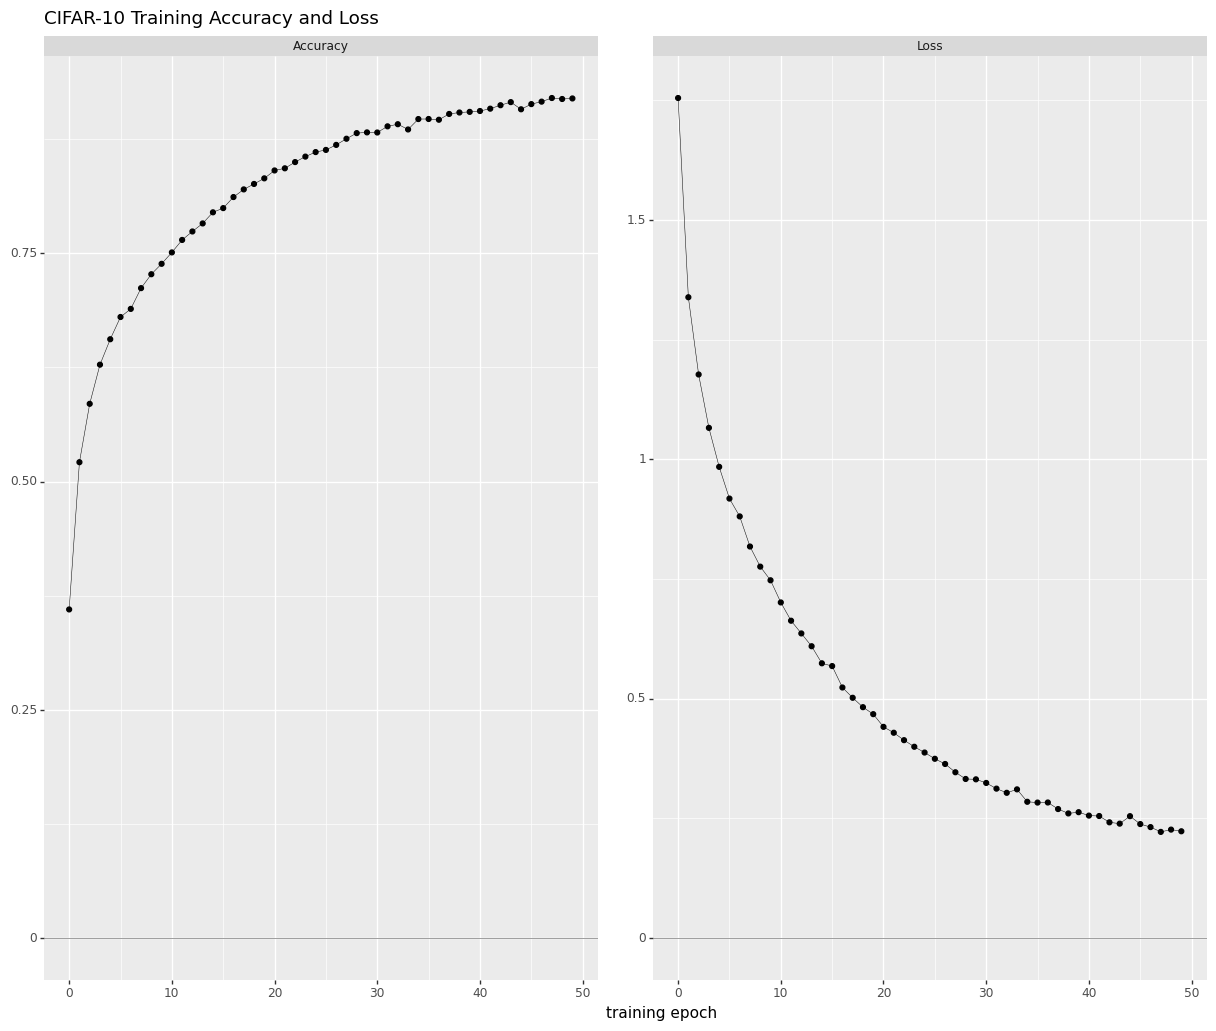

In [18]:
df = pd.DataFrame({'Loss': history_i.history['loss'], 'Accuracy': history_i.history['accuracy']})
df = df.reset_index()
df = df.melt(id_vars = ['index'])

pl = (ggplot()
      + geom_hline(yintercept = 0, colour = 'grey', size = 0.3)
      + geom_point(df, aes(x = 'index', y = 'value'))
      + geom_line(df, aes(x = 'index', y = 'value'), size = 0.2)
      + scale_x_continuous(name = 'training epoch')
      + scale_y_continuous(name = '')
      + facet_wrap('~variable', scales = 'free_y')
      + ggtitle('CIFAR-10 Training Accuracy and Loss')
      + theme(
          subplots_adjust={'wspace': 0.10},
          title = element_text(ha = 'left'),
      )
     )

print(pl)
                